In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.measure import shannon_entropy as entropy
from skimage.filters import sobel
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns
import pandas as pd

## Load Images from Dataset

In [2]:
def loading_images(path): # defining loading images from the dataset folder function
    images,labels=[],[]
    for subpath in os.listdir(path):
        subpath_path=os.path.join(path,subpath)
        if os.path.isdir(subpath_path):
            label=subpath  # using the subfolder name as the label like "lemon_good" or "Mango__bad"
            for filename in os.listdir(subpath_path):
                file_path=os.path.join(subpath_path,filename)
                image=cv2.imread(file_path)
                if image is not None:
                    image=cv2.resize(image,(128,128)) #resizing them to 128x128
                    images.append(image)
                    labels.append(label)
    return images,labels

In [3]:
path="dataset" # setting our dataset folder path
images,labels=loading_images(path) # calling loading_images function
labels_binary=[0 if "good" in label else 1 for label in labels] # mapping the text labels into binary values 0 for good and 1 for bad

## Class Distribution before dividing the dataset

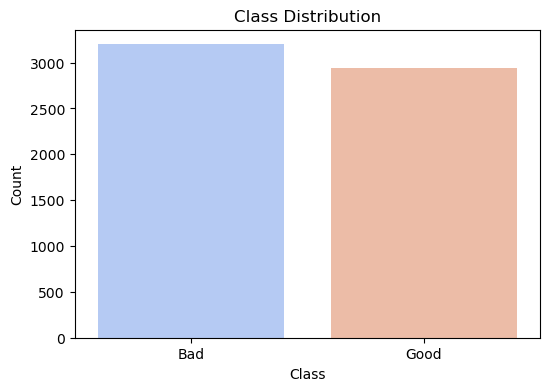

In [4]:
label_names = ["Good" if label == 0 else "Bad" for label in labels_binary] # creating readable label names for visualization
plt.figure(figsize=(6, 4))
sns.countplot(x=label_names, palette="coolwarm") # plotting the class distribution using seaborn
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Split Data into Train, Validation, and Test Sets

In [5]:
X_train,X_temp,y_train,y_temp=train_test_split(images,labels_binary,test_size=0.4,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)
print("Number of Images in Training Set (Images,Labels): {},{}".format(len(X_train),len(y_train)))
print("Number of Images in Validation Set (Images,Labels): {},{}".format(len(X_val),len(y_val)))
print("Number of Images in Testing Set (Images,Labels): {},{}".format(len(X_test),len(y_test)))

Number of Images in Training Set (Images,Labels): 3681,3681
Number of Images in Validation Set (Images,Labels): 1227,1227
Number of Images in Testing Set (Images,Labels): 1228,1228


## Sample Images from each class

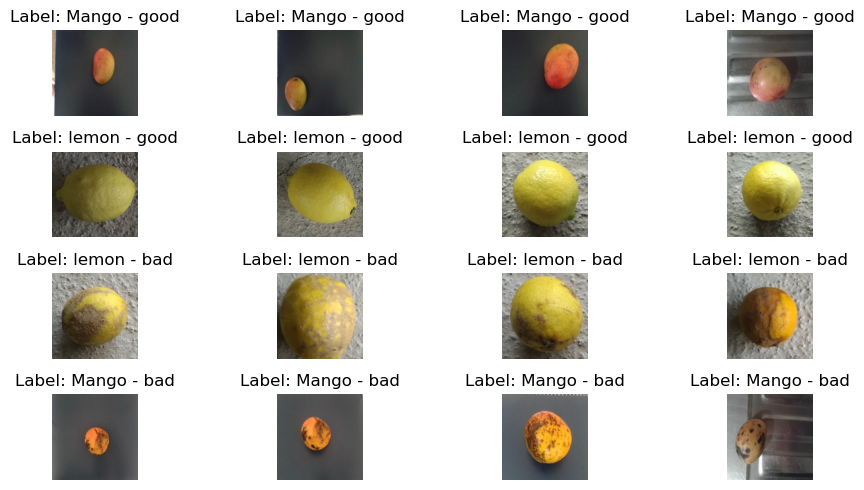

In [6]:
def show_sample_images(images,labels,num_samples=8):
    unique_labels=list(set(labels))
    selected_images=[]
    selected_labels=[]
    for label in unique_labels: # selecting images from each label
        indices=[i for i,l in enumerate(labels) if l==label]
        selected_indices=indices[:4]  # selecting first 4 images for each label
        for idx in selected_indices:
            selected_images.append(images[idx])
            selected_labels.append(label)
    selected_images=np.array(selected_images) # converting to NumPy array
    # displaying images
    fig,axes=plt.subplots(4,4,figsize=(10,5))
    axes=axes.ravel()
    for i in range(len(selected_images)):
        axes[i].imshow(cv2.cvtColor(selected_images[i],cv2.COLOR_BGR2RGB))
        axes[i].set_title("Label: {}".format(" - ".join(selected_labels[i].split("__"))))
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
show_sample_images(images,labels)

## Background Removal Using HSV Thresholding

In [7]:
def adjust_gamma(image,gamma=1.2): # defining function to adjust image brightness using gamma correction
    invGamma=1.0/gamma # increasing gamma(>1) to brighten, decreasing (<1) to darken
    table=np.array([((i/255.0) ** invGamma)*255 for i in range(256)]).astype("uint8") # creating a lookup table to adjust brightness
    return cv2.LUT(image,table)

def remove_background_hsv(img): #function to remove background using gamma correction, hsv thresholding, morphological operations,using canny edge and contour extraction
    img_bright=adjust_gamma(img,gamma=1.2) # adjusting the brightness by calling adjust_gamma function
    hsv=cv2.cvtColor(img_bright,cv2.COLOR_BGR2HSV) # converting BGR to HSV
    # setting HSV thresholds to capture green/yellow/orange and red
    lower_bound1=np.array([10,65,60]) # range for green/yellow/orange
    upper_bound1=np.array([75,255,255])
    mask1=cv2.inRange(hsv,lower_bound1,upper_bound1)
    
    lower_bound2=np.array([0,65,60]) # range for lower red/orange 
    upper_bound2=np.array([10,255,255])
    mask2=cv2.inRange(hsv,lower_bound2,upper_bound2)

    lower_bound3=np.array([170,65,60]) # range for upper red/orange
    upper_bound3=np.array([180,255,255])
    mask3=cv2.inRange(hsv,lower_bound3,upper_bound3)
    
    combined_mask=mask1 | mask2 | mask3 # combining the masks
    mask_blurred=cv2.GaussianBlur(combined_mask,(5,5),0) # using gaussian blur 
    kernel=np.ones((3,3),np.uint8) 
    mask_opened=cv2.morphologyEx(mask_blurred,cv2.MORPH_OPEN,kernel,iterations=1) # performing opening with kernel size 3*3
    mask_closed=cv2.morphologyEx(mask_opened,cv2.MORPH_CLOSE,kernel,iterations=1) # performing closing 
    mask_dilated=cv2.dilate(mask_closed,kernel,iterations=1) # performing dilate
    edges=cv2.Canny(img,100,200) # applying canny edge detection
    edges_dilated=cv2.dilate(edges,kernel,iterations=1) # dilating the edges
    refined_mask=cv2.bitwise_and(mask_dilated,cv2.bitwise_not(edges_dilated)) # refining the mask by subtracting the dilated edges
    # finding contours and drawing the largest one using convex hull for a smooth mask 
    contours,hierarchy=cv2.findContours(refined_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    final_mask=np.zeros_like(refined_mask)
    if hierarchy is not None:
        for i,cnt in enumerate(contours):
            if hierarchy[0][i][3]==-1 and cv2.contourArea(cnt) > 500:
                hull=cv2.convexHull(cnt)
                cv2.drawContours(final_mask,[hull],-1,255,-1)
    return cv2.bitwise_and(img,img,mask=final_mask) # returning the original image with the background removed

## Feature Extraction - Histogram & Texture Analysis

In [8]:
def extract_features(img): # defining function to extract features from processes image, computing histograms,edge density and entropy
    hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hue_hist=np.histogram(hsv[:,:,0],bins=32,range=(0,180))[0]
    sat_hist=np.histogram(hsv[:,:,1],bins=32,range=(0,255))[0]
    val_hist=np.histogram(hsv[:,:,2],bins=32,range=(0,255))[0]
    edge_density=np.mean(sobel(gray))
    entropy_val=entropy(gray)
    return np.concatenate((hue_hist,sat_hist,val_hist,[edge_density,entropy_val]))

## Optimize Thresholds Using Training Set

In [9]:
def optimize_thresholds(X_train, y_train): # defining function to optimize thresholds based on training data
    edge_densities = []
    entropies = []
    for img in X_train:
        img_processed = remove_background_hsv(img)
        features = extract_features(img_processed)
        edge_densities.append(features[-2])
        entropies.append(features[-1])
    edge_threshold = np.mean(edge_densities) # computing mean threshold based on training data
    entropy_threshold = np.mean(entropies)
    return edge_threshold, entropy_threshold

## Classification Based on Color & Texture Features

In [17]:
def classify_produce(features,edge_threshold=0.1, entropy_threshold=5.0): # defining function to classify produce based on density and entropy
    edge_density,entropy_val=features[-2],features[-1] 
    if edge_density>0.1 or entropy_val>5.0: # if edge density>0.1 or entropy>5.0 we are labeling it as Bad otherwise good
        return "Bad"
    return "Good"

## Feature Distributions

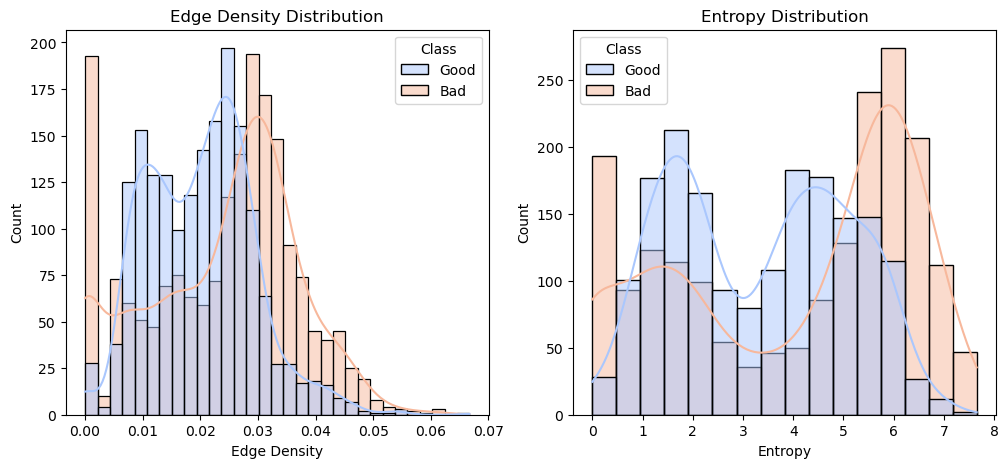

In [18]:
def plot_feature_distribution(X,y): # defining function to plot feature distributions for edge density and entropy
    features_data=[]
    for i,img in enumerate(X):
        img_processed=remove_background_hsv(img)
        features=extract_features(img_processed)
        features_data.append([y[i],features[-2],features[-1]])  # taking edge density & entropy
    df=pd.DataFrame(features_data,columns=["Class","Edge Density","Entropy"])
    df["Class"]=df["Class"].map({0: "Good",1: "Bad"})
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df,x="Edge Density",hue="Class",kde=True,palette="coolwarm")
    plt.title("Edge Density Distribution")
    plt.subplot(1,2,2)
    sns.histplot(df,x="Entropy",hue="Class",kde=True,palette="coolwarm")
    plt.title("Entropy Distribution")
    plt.show()
plot_feature_distribution(X_train,y_train)

## Hue Histogram Comparison (Good vs. Bad Produce)

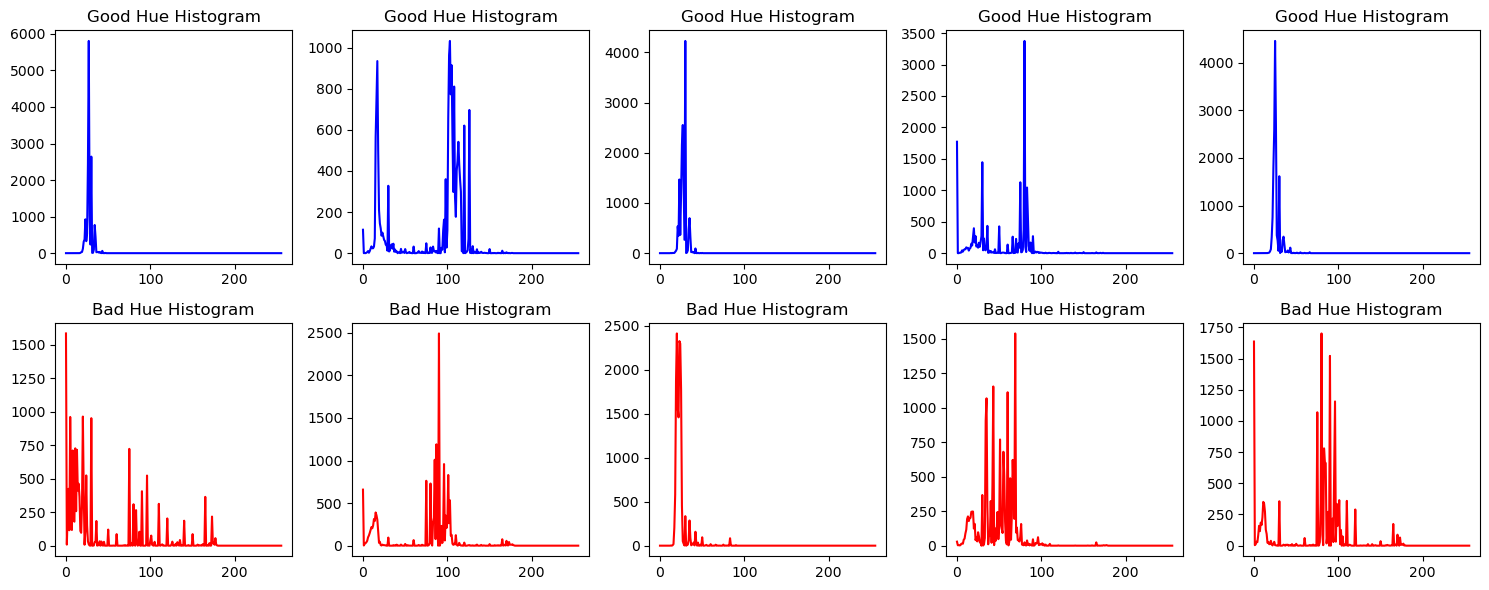

In [19]:
def plot_hue_histogram(X,y,num_samples=5): # defining function in plotting hue histograms for a few(5) sample images per class
    fig,axes=plt.subplots(2,num_samples,figsize=(15,6))
    unique_classes=[0,1]  # 0=Good,1=Bad
    for i,label in enumerate(unique_classes):
        class_indices=[idx for idx,l in enumerate(y) if l == label]
        selected_indices=random.sample(class_indices,min(num_samples,len(class_indices)))
        for j,idx in enumerate(selected_indices):
            img=cv2.cvtColor(X[idx],cv2.COLOR_BGR2HSV)
            hue_hist=np.histogram(img[:,:,0].ravel(),bins=256,range=(0,256))[0]
            axes[i,j].plot(hue_hist,color="blue" if label == 0 else "red")
            axes[i,j].set_title(f"{'Good' if label == 0 else 'Bad'} Hue Histogram")
    plt.tight_layout()
    plt.show()
plot_hue_histogram(X_train,y_train)

## Evaluate the Model

In [20]:
def model(X,y,path,results,edge_threshold=None,entropy_threshold=None):# defining function to evaluate our simple classifier
    y_pred=[]
    if(path=="Training Set"):
        edge_densities=[]
        entropies=[]
        for img in X:
            img_processed=remove_background_hsv(img) # calling background removal function
            features=extract_features(img_processed) # calling extract feature function
            edge_densities.append(features[-2])
            entropies.append(features[-1])
            prediction=classify_produce(features) # calling classify produce function 
            y_pred.append(0 if prediction=="Good" else 1)
        edge_threshold=np.mean(edge_densities) # computing mean thresholds based on training data
        entropy_threshold=np.mean(entropies)
    else:
        for img in X:
            img_processed=remove_background_hsv(img)
            features=extract_features(img_processed)
            prediction=classify_produce(features,edge_threshold,entropy_threshold)
            y_pred.append(0 if prediction=="Good" else 1)
            
    accuracy=accuracy_score(y,y_pred) # accuracy score
    results[path]=accuracy*100
    print(f"{path} Classification Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n",classification_report(y,y_pred,target_names=["Good","Bad"])) # classification report
    cm=confusion_matrix(y,y_pred) # confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["Good","Bad"],yticklabels=["Good","Bad"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({path})")
    plt.show()
    
    if(path=="Training Set"):
        return edge_threshold,entropy_threshold

In [21]:
#to store the results in a dictionary
results = {}

## Evaluation on the Training data

Training Set Classification Accuracy: 64.33%

Classification Report:
               precision    recall  f1-score   support

        Good       0.60      0.79      0.68      1778
         Bad       0.72      0.51      0.60      1903

    accuracy                           0.64      3681
   macro avg       0.66      0.65      0.64      3681
weighted avg       0.66      0.64      0.64      3681



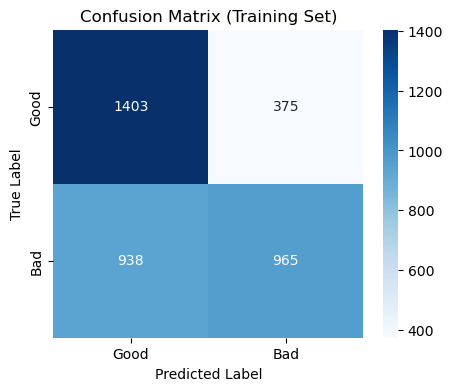

In [22]:
edge_threshold,entropy_threshold=model(X_train,y_train,"Training Set",results) # calling model function

## Evaluation on the Validation data

Validation Set Classification Accuracy: 65.04%

Classification Report:
               precision    recall  f1-score   support

        Good       0.59      0.81      0.68       577
         Bad       0.75      0.51      0.61       650

    accuracy                           0.65      1227
   macro avg       0.67      0.66      0.65      1227
weighted avg       0.68      0.65      0.64      1227



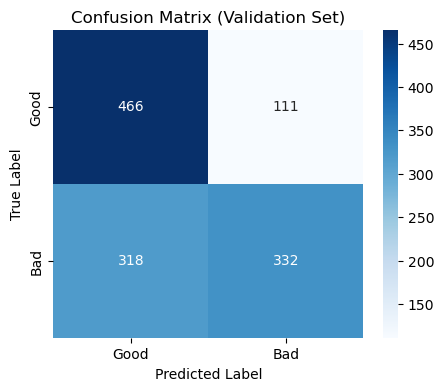

In [23]:
model(X_val,y_val,"Validation Set",results,edge_threshold,entropy_threshold)

## Evaluation on the Testing data

Test Set Classification Accuracy: 63.44%

Classification Report:
               precision    recall  f1-score   support

        Good       0.59      0.77      0.67       583
         Bad       0.71      0.51      0.60       645

    accuracy                           0.63      1228
   macro avg       0.65      0.64      0.63      1228
weighted avg       0.65      0.63      0.63      1228



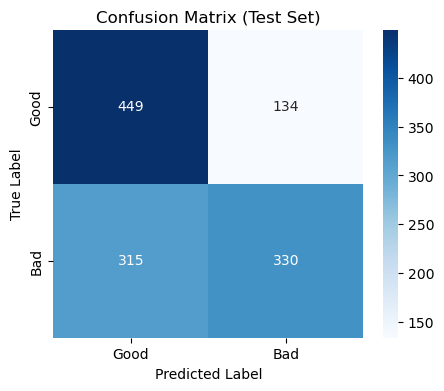

In [24]:
model(X_test,y_test,"Test Set",results,edge_threshold,entropy_threshold)

## Plot the Accuracy Comparison

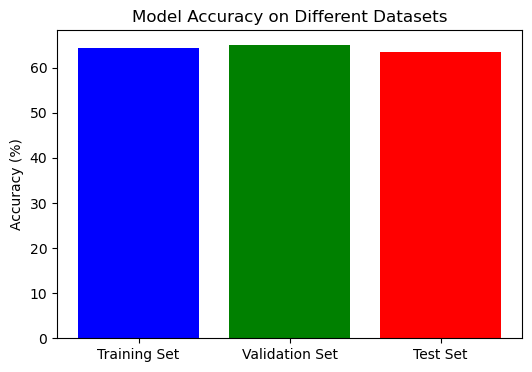

In [25]:
plt.figure(figsize=(6,4))
plt.bar(results.keys(),results.values(),color=['blue','green','red'])
plt.title("Model Accuracy on Different Datasets")
plt.ylabel("Accuracy (%)")
plt.show()

## Display Processed Images and Final Output from Test set

In [28]:
def randomly_display_images(X,y,dataset_name,edge_threshold,entropy_threshold,nsamples=7): # function to randomly displaying 7 images from the test set with their predictions
    selected_indices=random.sample(range(len(X)),min(nsamples,len(X)))
    for idx in selected_indices:
        img=X[idx]
        img_processed=remove_background_hsv(img)
        features=extract_features(img_processed)
        prediction=classify_produce(features,edge_threshold,entropy_threshold)
        hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        edges=cv2.Canny(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),50,150)
        fig,axs=plt.subplots(1,5,figsize=(25,5))
        axs[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        axs[0].set_title(f"{y[idx]}")
        axs[0].axis("off")
        axs[1].imshow(hsv[:,:,0],cmap='hsv')
        axs[1].set_title("Hue Channel")
        axs[1].axis("off")
        axs[2].imshow(edges,cmap='gray')
        axs[2].set_title("Edges")
        axs[2].axis("off")
        axs[3].hist(hsv[:,:,0].ravel(),bins=256,range=(0,256),color='gray')
        axs[3].set_title("Histogram")
        axs[4].imshow(cv2.cvtColor(img_processed,cv2.COLOR_BGR2RGB))
        axs[4].set_title(f"Final: {prediction}")
        axs[4].axis("off")
        plt.tight_layout()
        plt.show()

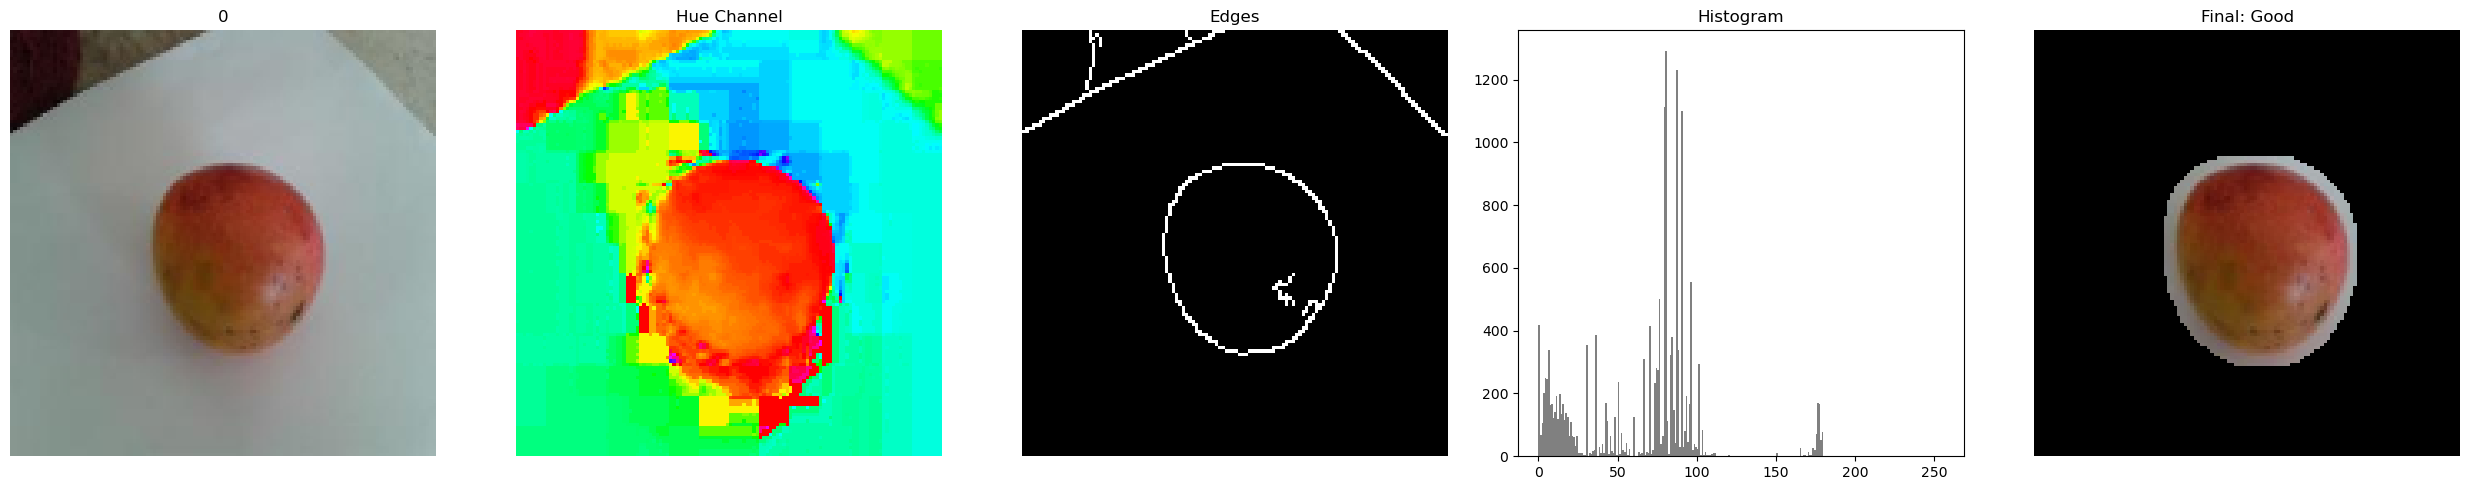

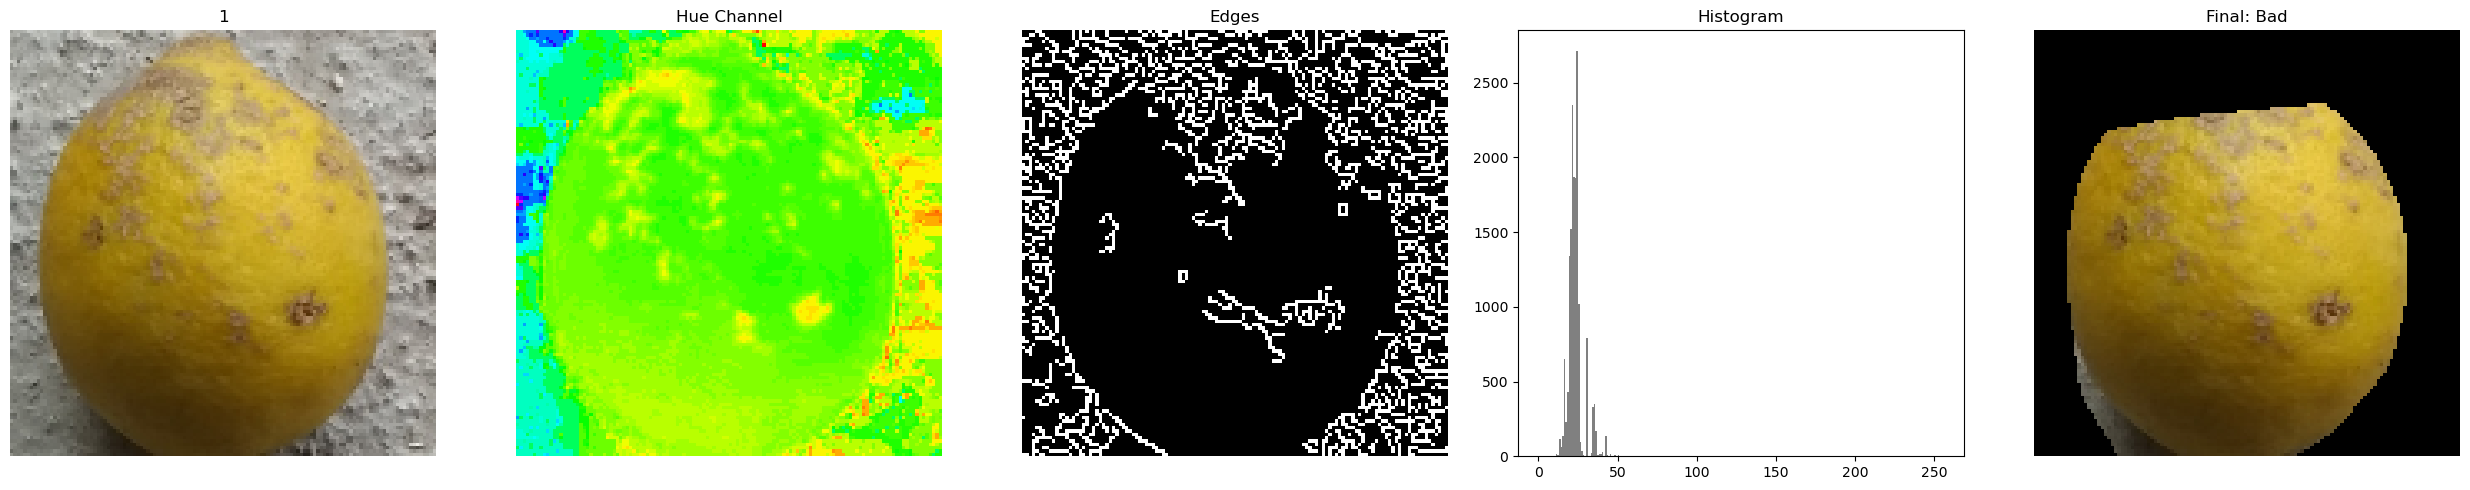

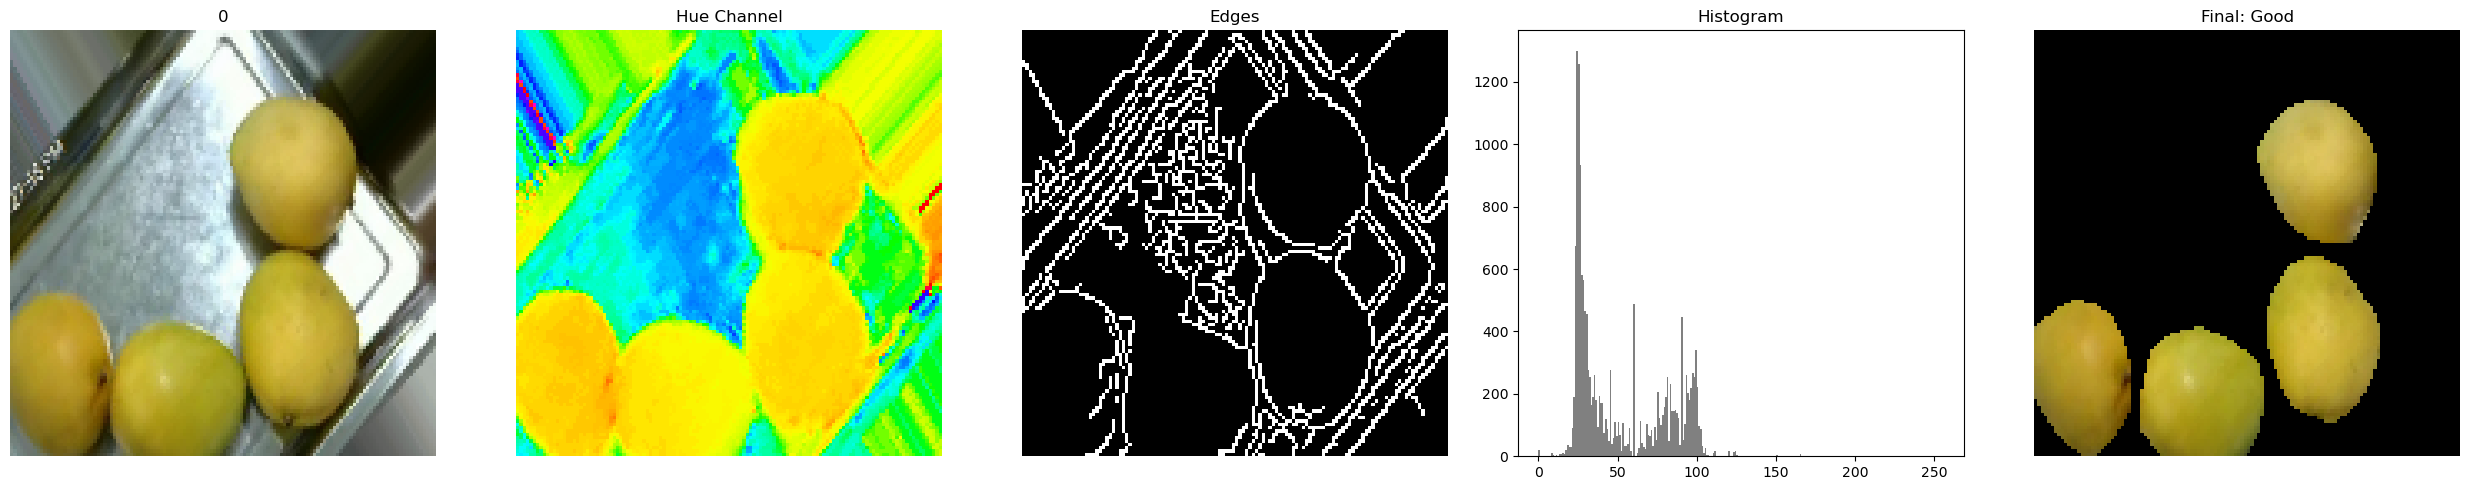

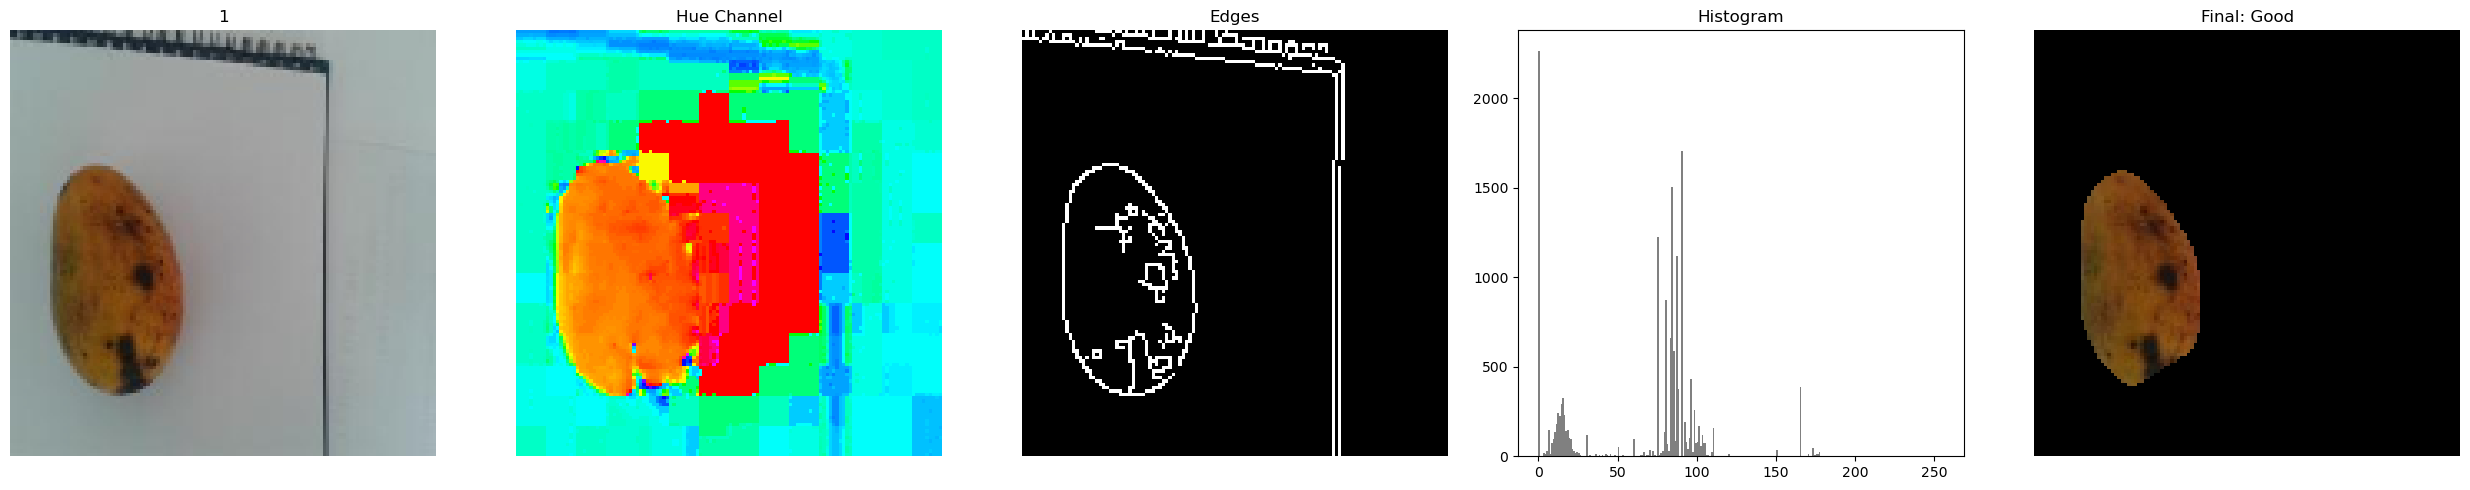

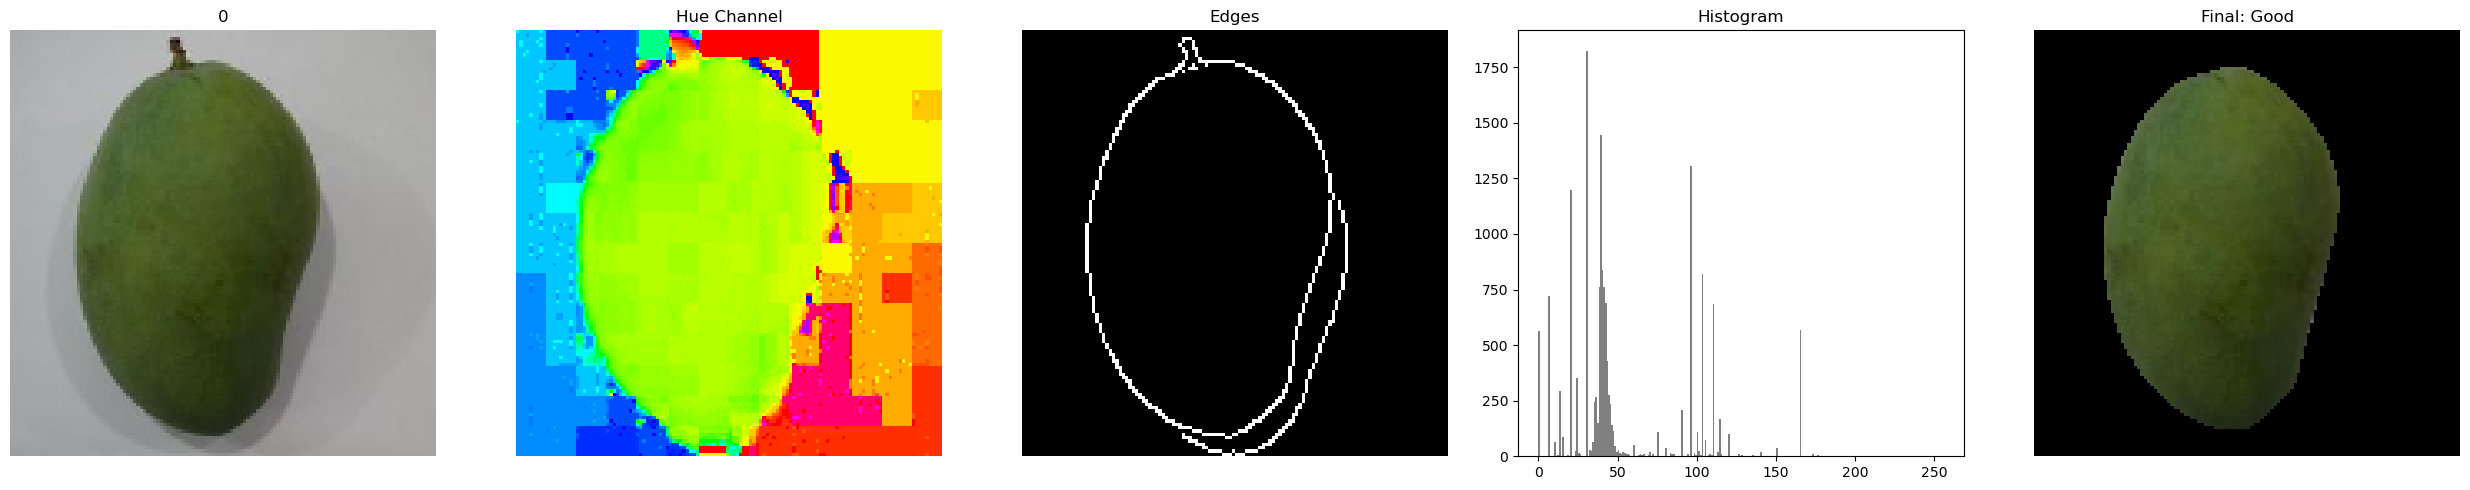

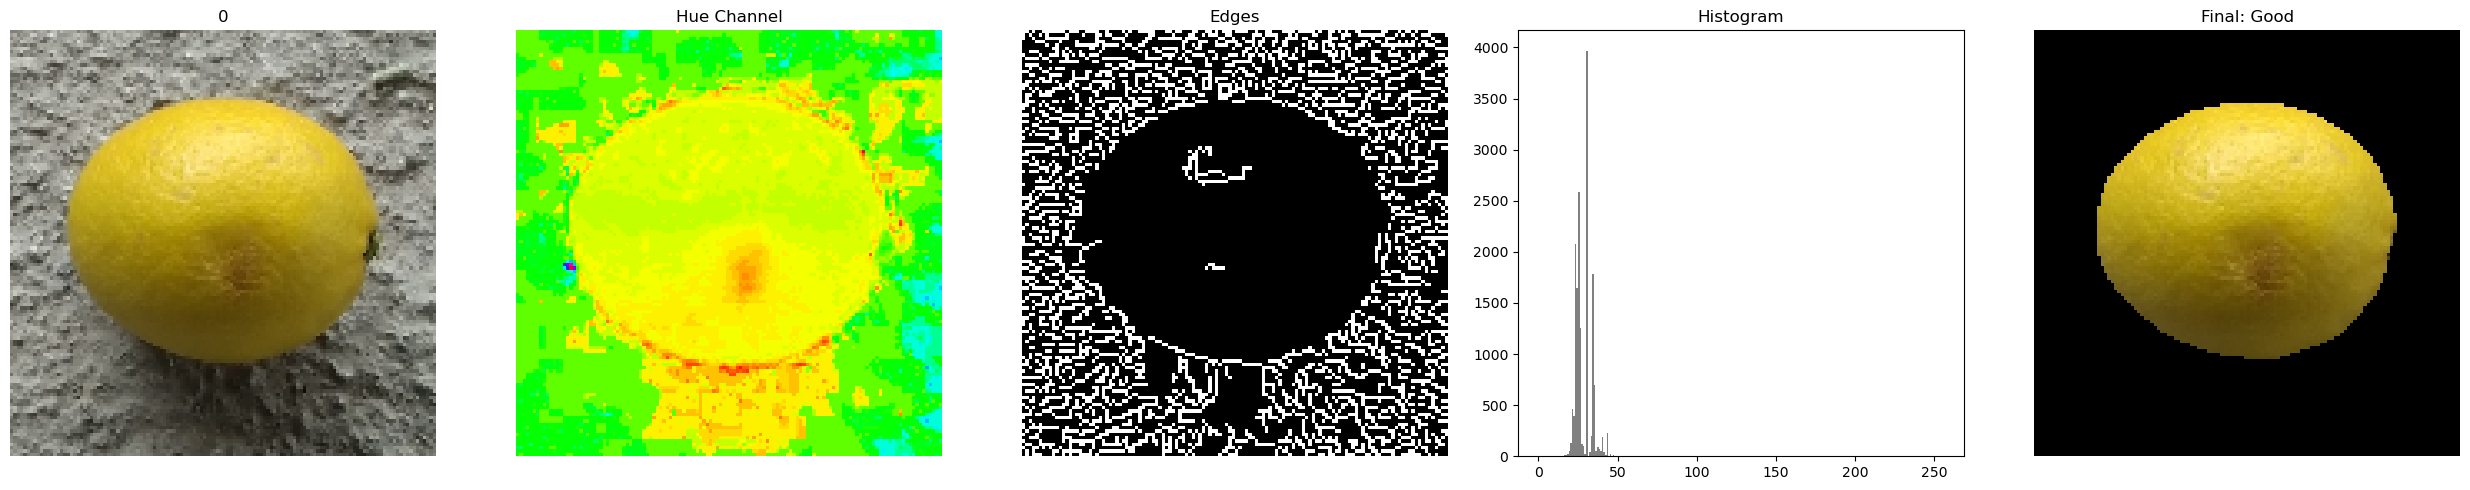

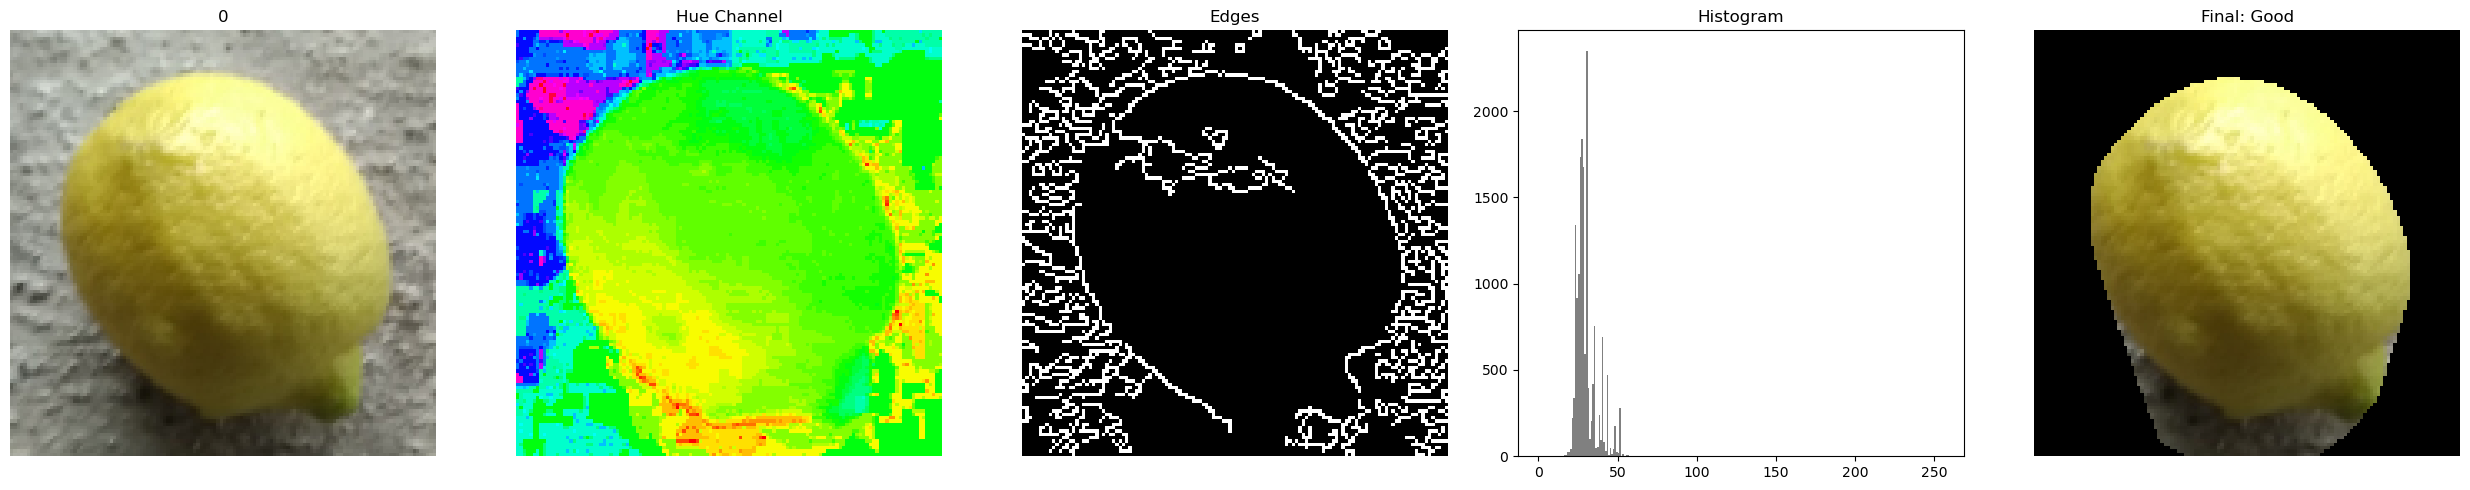

In [32]:
randomly_display_images(X_test,y_test,"Test Set",edge_threshold,entropy_threshold) # calling randomly display function